In [1]:
%pylab inline
import scipy
from scipy.sparse import coo_matrix, block_diag, identity, hstack
#import matplotlib as mpl
import matplotlib.pyplot as plt
from pyiga import bspline, vform, geometry, vis, solvers, utils, topology
from pyiga import assemble
#from patchmesh import *
from sksparse.cholmod import cholesky
#from patchmesh3D import *
#from multipatch import *

from pyiga import bspline
from pyiga import utils
from pyiga.bspline import BSplineFunc
from pyiga.tensor import apply_tprod
from pyiga import adaptive as adap

import functools
import itertools

numpy.set_printoptions(linewidth=100000)
numpy.set_printoptions(precision=5)

Populating the interactive namespace from numpy and matplotlib


In [2]:
def adaptive(M, nu, j, Ma_T, theta=0.9, maxiter=12, plotrange=(-1,1), draw=False):
    params=dict()
    numdofs=np.zeros(maxiter)
    L2err=np.zeros(maxiter)
    H1err=np.zeros(maxiter)
    err_est=np.zeros(maxiter)
    err_indicator=[]
    refined=[]
    P = []
    #params['u_sol']=u_sol
    # params['ux']=ux
    # params['uy']=uy
    MP = assemble.Multipatch(M, automatch = True)
    
    for iter in range(maxiter):
        print(iter)
        if draw:
            fig = plt.figure()
            MP.mesh.draw(fig, knots=False)
            plt.axis('scaled');
            plt.show()
        
        # ---------------------------------------------------------------------
        # SOLVE
        # ---------------------------------------------------------------------
        
        numdofs[iter] = MP.numdofs
        #implement Dirichlet boundary conditions
        
#         print(MP.Basis.shape)
#         print(MP.numdofs)
        bcs = MP.compute_dirichlet_bcs({0:0})
        #print(bcs)

        # assemble the linear system
        Kh = sum([MP.assemble_volume(vform.stiffness_vf(2,a=nu[k]),domain_id=k) for k in nu])
        F = sum([MP.assemble_volume('j * v + inner(Ma_T, grad(v)) * dx', arity=1, domain_id=k, Ma_T=Ma_T[k], j=j[k], physical=True) for k in ['M1','M2']],axis=0)

        #eliminate boundary conditions
        LS = assemble.RestrictedLinearSystem(Kh, F, bcs)
        #solve system and L2 project exact solution into discrete space
        uh = LS.complete((cholesky(LS.A))(LS.b))
        #u_ = (cholesky(Mh))(u_rhs)
        #print(check_coupling(MP,u_))
        
        #eh=uh-u_
        #L2err[iter] = sqrt(eh.T@Mh@eh)
        #H1err[iter] = sqrt(eh.T@Kh@eh + L2err[iter]**2)
        
        # ---------------------------------------------------------------------
        # ESTIMATE AND REFINE
        # ---------------------------------------------------------------------
        
        if iter < maxiter-1:
            start=time.time()
            err_indicator.append(adap.PoissonEstimator(MP,uh,f=j,a=nu, M=Ma_T, physical=True))
            err_est[iter] = norm(err_indicator[-1])
            marked_patches = adap.doerfler_marking(err_indicator[-1], theta)
            end = time.time()
            print("Estimate and Marking took " + str(end - start) + " seconds.")
            
            marked_patches = {p:None for p in marked_patches}
            refined.append(marked_patches)
            #print(MP.numdofs)
            start = time.time()
            P_i = MP.patch_refine(h_ref=marked_patches, return_P = True)
            for i in range(len(P)):
                P[i]=P_i@P[i]
            P.append(P_i)
            end = time.time()
            print("Refinement took " + str(end - start) + " seconds.")
            
            # start=time.time()
            # MP = assemble.Multipatch(M, automatch = True)
            # end = time.time()
            print("Basis setup took " + str(end-start) + " seconds.")
            #MP.patch_refine(patches=marked_patches, return_prol=False)
            #MP.mesh.draw(patch_idx=True)
            #uh = [geometry.BSplineFunc(MP.mesh.patches[p][0][0], MP.global_to_patch(p) @ u_) for p in range(len(MP.mesh.patches))]
        

    # restrict solution to each individual patch
    #uh = [geometry.BSplineFunc(MP.mesh.patches[p][0][0], MP.global_to_patch(p) @ u_) for p in range(len(MP.mesh.patches))]

    #for (uh, ((kvs, geo),_)) in zip(uh, MP.mesh.patches):
        #vis.plot_field(uh, geo, vmin=plotrange[0], vmax=plotrange[1])
    #plt.axis('scaled')
    #plt.colorbar();
    
    return MP, uh, numdofs, L2err, H1err, err_est, err_indicator, refined, P

In [3]:
def Motor(deg,N,full=False):
    deg=2
    X=(bspline.make_knots(deg,0.0,1.0,3*N),)+3*(bspline.make_knots(deg,0.0,1.0,N),)+(bspline.make_knots(deg,0.0,1.0,2*N),)
    Y=2*(bspline.make_knots(deg,0.0,1.0,N),)+(bspline.make_knots(deg,0.0,1.0,3*N),)+3*(bspline.make_knots(deg,0.0,1.0,N),)+(bspline.make_knots(deg,0.0,1.0,3*N),)+2*(bspline.make_knots(deg,0.0,1.0,N),)
    kvs=list(itertools.product(X,Y))
    kvs=[(kv1,kv0) for kv0, kv1 in kvs]
    #kvs = 45*[2 * (bspline.make_knots(deg, 0.0, 1.0, N),),]
    a,b,c,d,e,f=.3,1.,1.1,1.15,1.16,1.5
    th_m,th_air,th_fe=31.,2.,5. # 2*th_m + 4*th_air + 2*th_fe = 90!!!
    geos=[
        geometry.annulus(r1=a,r2=b,phi=2*pi*th_fe/360),
        geometry.annulus(r1=a,r2=b,phi=2*pi*th_air/360).rotate_2d(2*pi*th_fe/360),
        geometry.annulus(r1=a,r2=b,phi=2*pi*th_m/360).rotate_2d(2*pi*(th_air+ th_fe)/360),                   
        geometry.annulus(r1=a,r2=b,phi=2*pi*th_air/360).rotate_2d(2*pi*(th_m+th_air+th_fe)/360),            
        geometry.annulus(r1=a,r2=b,phi=2*pi*2*th_fe/360).rotate_2d(2*pi*(th_m+th_air*2+th_fe)/360),           
        geometry.annulus(r1=a,r2=b,phi=2*pi*th_air/360).rotate_2d(2*pi*(th_m+th_air*2+th_fe*3)/360),     
        geometry.annulus(r1=a,r2=b,phi=2*pi*th_m/360).rotate_2d(2*pi*(th_m+th_air*3+th_fe*3)/360),       
        geometry.annulus(r1=a,r2=b,phi=2*pi*th_air/360).rotate_2d(2*pi*(th_m*2+th_air*3+th_fe*3)/360),   
        geometry.annulus(r1=a,r2=b,phi=2*pi*th_fe/360).rotate_2d(2*pi*(th_m*2+th_air*4+th_fe*3)/360),    
        
        geometry.annulus(r1=b,r2=c,phi=2*pi*th_fe/360),
        geometry.annulus(r1=b,r2=c,phi=2*pi*th_air/360).rotate_2d(2*pi*th_fe/360),
        geometry.annulus(r1=b,r2=c,phi=2*pi*th_m/360).rotate_2d(2*pi*(th_air+ th_fe)/360),                   
        geometry.annulus(r1=b,r2=c,phi=2*pi*th_air/360).rotate_2d(2*pi*(th_m+th_air+th_fe)/360),            
        geometry.annulus(r1=b,r2=c,phi=2*pi*2*th_fe/360).rotate_2d(2*pi*(th_m+th_air*2+th_fe)/360),           
        geometry.annulus(r1=b,r2=c,phi=2*pi*th_air/360).rotate_2d(2*pi*(th_m+th_air*2+th_fe*3)/360),     
        geometry.annulus(r1=b,r2=c,phi=2*pi*th_m/360).rotate_2d(2*pi*(th_m+th_air*3+th_fe*3)/360),       
        geometry.annulus(r1=b,r2=c,phi=2*pi*th_air/360).rotate_2d(2*pi*(th_m*2+th_air*3+th_fe*3)/360),   
        geometry.annulus(r1=b,r2=c,phi=2*pi*th_fe/360).rotate_2d(2*pi*(th_m*2+th_air*4+th_fe*3)/360), 
        
        geometry.annulus(r1=c,r2=d,phi=2*pi*th_fe/360),
        geometry.annulus(r1=c,r2=d,phi=2*pi*th_air/360).rotate_2d(2*pi*th_fe/360),
        geometry.annulus(r1=c,r2=d,phi=2*pi*th_m/360).rotate_2d(2*pi*(th_air+ th_fe)/360),                   
        geometry.annulus(r1=c,r2=d,phi=2*pi*th_air/360).rotate_2d(2*pi*(th_m+th_air+th_fe)/360),            
        geometry.annulus(r1=c,r2=d,phi=2*pi*2*th_fe/360).rotate_2d(2*pi*(th_m+th_air*2+th_fe)/360),           
        geometry.annulus(r1=c,r2=d,phi=2*pi*th_air/360).rotate_2d(2*pi*(th_m+th_air*2+th_fe*3)/360),     
        geometry.annulus(r1=c,r2=d,phi=2*pi*th_m/360).rotate_2d(2*pi*(th_m+th_air*3+th_fe*3)/360),       
        geometry.annulus(r1=c,r2=d,phi=2*pi*th_air/360).rotate_2d(2*pi*(th_m*2+th_air*3+th_fe*3)/360),   
        geometry.annulus(r1=c,r2=d,phi=2*pi*th_fe/360).rotate_2d(2*pi*(th_m*2+th_air*4+th_fe*3)/360), 
        
        geometry.annulus(r1=d,r2=e,phi=2*pi*th_fe/360),
        geometry.annulus(r1=d,r2=e,phi=2*pi*th_air/360).rotate_2d(2*pi*th_fe/360),
        geometry.annulus(r1=d,r2=e,phi=2*pi*th_m/360).rotate_2d(2*pi*(th_air+ th_fe)/360),                   
        geometry.annulus(r1=d,r2=e,phi=2*pi*th_air/360).rotate_2d(2*pi*(th_m+th_air+th_fe)/360),            
        geometry.annulus(r1=d,r2=e,phi=2*pi*2*th_fe/360).rotate_2d(2*pi*(th_m+th_air*2+th_fe)/360),           
        geometry.annulus(r1=d,r2=e,phi=2*pi*th_air/360).rotate_2d(2*pi*(th_m+th_air*2+th_fe*3)/360),     
        geometry.annulus(r1=d,r2=e,phi=2*pi*th_m/360).rotate_2d(2*pi*(th_m+th_air*3+th_fe*3)/360),       
        geometry.annulus(r1=d,r2=e,phi=2*pi*th_air/360).rotate_2d(2*pi*(th_m*2+th_air*3+th_fe*3)/360),   
        geometry.annulus(r1=d,r2=e,phi=2*pi*th_fe/360).rotate_2d(2*pi*(th_m*2+th_air*4+th_fe*3)/360), 
        
        geometry.annulus(r1=e,r2=f,phi=2*pi*th_fe/360),
        geometry.annulus(r1=e,r2=f,phi=2*pi*th_air/360).rotate_2d(2*pi*th_fe/360),
        geometry.annulus(r1=e,r2=f,phi=2*pi*th_m/360).rotate_2d(2*pi*(th_air+ th_fe)/360),                   
        geometry.annulus(r1=e,r2=f,phi=2*pi*th_air/360).rotate_2d(2*pi*(th_m+th_air+th_fe)/360),            
        geometry.annulus(r1=e,r2=f,phi=2*pi*2*th_fe/360).rotate_2d(2*pi*(th_m+th_air*2+th_fe)/360),           
        geometry.annulus(r1=e,r2=f,phi=2*pi*th_air/360).rotate_2d(2*pi*(th_m+th_air*2+th_fe*3)/360),     
        geometry.annulus(r1=e,r2=f,phi=2*pi*th_m/360).rotate_2d(2*pi*(th_m+th_air*3+th_fe*3)/360),       
        geometry.annulus(r1=e,r2=f,phi=2*pi*th_air/360).rotate_2d(2*pi*(th_m*2+th_air*3+th_fe*3)/360),   
        geometry.annulus(r1=e,r2=f,phi=2*pi*th_fe/360).rotate_2d(2*pi*(th_m*2+th_air*4+th_fe*3)/360),
    ]

    Fe = {0,1,2,3,4,5,6,7,8,9,13,17,18,19,20,21,22,23,24,25,26,36,37,38,39,40,41,42,43,44}
    Air={10,12,14,16,27,28,29,30,31,32,33,34,35}
    M1={11}
    M2={15}

    if full:
        kvs=4*kvs
        Fe = set().union(*[{x + 45*i for x in Fe} for i in range(4)])
        Air = set().union(*[{x + 45*i for x in Air} for i in range(4)])
        M1 = set().union(*[{x + 45*i for x in M1} for i in range(4)])
        M2 = set().union(*[{x + 45*i for x in M2} for i in range(4)])
        geos = [g for g in geos] + [g.rotate_2d(pi/2) for g in geos] + [g.rotate_2d(pi) for g in geos] + [g.rotate_2d(3/2*pi) for g in geos]

    patches = [(k, g) for k, g in zip(kvs,geos)]
    patches = [(tuple(bspline.mapto(k[d],lambda x: g.support[d][1]*x + g.support[d][0]*(1-x)) for d in range(2)), g) for k, g in zip(kvs,geos)]
    #patches = [(k, g) for k, g in zip(kvs,geos)]

    t=time.time()
    M = topology.PatchMesh(patches, domains={'M1':M1,'M2':M2,'Fe':Fe,'Air':Air})
    print('Detecting interfaces took ' + str(time.time()-t) + ' seconds.')
    
    if not full:                            #periodic boundary conditions
        M.remove_boundary({(0,0),(9,0),(18,0),(27,0),(36,0),(8,1),(17,1),(26,1),(35,1),(44,1)})
        #M.add_interface(0 ,0,0,8 ,1,0,(False,))
        #M.add_interface(9 ,0,0,17,1,0,(False,))
        #M.add_interface(18,0,0,26,1,0,(False,))
        #M.add_interface(27,0,0,35,1,0,(False,))
        #M.add_interface(36,0,0,44,1,0,(False,))
    return M
#M.set_boundary_id({'D1':{(0,2),(8,2),(16,2),(24,2)}})
#M.set_boundary_id({'D2':{(7,3),(15,3),(23,3),(31,3)}})

In [4]:
rho=1.28

nu = {'M1': 1e7/(4.344*pi), 'M2':1e7/(4.344*pi), 'Fe':1e5/(204*pi), 'Air': 1e7/(4*pi)}
#nu = {'M1': 1., 'M2': 1., 'Fe': 1., 'Air': 1.}

Ma_T = {'M1': lambda x,y: tuple(rho*nu['M1']*np.array([-y,x])/sqrt(x**2+y**2)), 
        'M2':lambda x,y: tuple(rho*nu['M2']*np.array([y,-x])/sqrt(x**2+y**2)), 
        'Fe':lambda x,y: (0.,0.), 
        'Air': lambda x,y: (0.,0.)}

j = {'M1': lambda x,y: 0.0, 'M2':lambda x,y: 0.0, 'Fe':lambda x,y: 0.0, 'Air': lambda x,y: 0.0}

In [7]:
deg=2
M=Motor(deg,deg+1)
MP = assemble.Multipatch(M, automatch=True)

for i in range(4):
    M.h_refine(patches=-1)
    MP = assemble.Multipatch(M, automatch=True)

Detecting interfaces took 2.6197338104248047 seconds.
Basis setup took 0.022542476654052734 seconds
Basis setup took 0.04592633247375488 seconds
Basis setup took 0.12939167022705078 seconds
Basis setup took 0.428159236907959 seconds
Basis setup took 1.56034255027771 seconds


In [5]:
deg=2
M=Motor(deg,deg+1)
MP = assemble.Multipatch(M, automatch=True)
maxiter=7
uh=[]
numdofs = np.zeros(maxiter,dtype=float)
P=[]
return_P = True

for i in range(maxiter):
    print(i)
    bcs = MP.compute_dirichlet_bcs({0:0.})
    Ah = sum([MP.assemble_volume(vform.stiffness_vf(2,a=nu[k]),domain_id=k) for k in nu])
    F = sum([MP.assemble_volume('(j * v + inner(Ma_T, grad(v))) * dx', arity=1, domain_id=k, Ma_T=Ma_T[k], j=j[k], physical=True) for k in j],axis=0)
    Kh = MP.assemble_volume(vform.stiffness_vf(2))
    Mh = MP.assemble_volume(vform.mass_vf(2))
    LS = assemble.RestrictedLinearSystem(Ah, F, bcs)
    uh.append(LS.complete((cholesky(LS.A))(LS.b)))
    numdofs[i] = MP.numdofs
    print(MP.numdofs)
    
    if i < maxiter-2 :
        P.append(MP.h_refine(h_ref=-1, return_P=return_P))
    elif i == maxiter-2:
        P.append(MP.p_refine(p_inc=1, return_P=return_P))
    else:
        pass
    
for k in reversed(range(1,len(P))):
    P[k-1]=P[k]@P[k-1]
    
L2err = np.zeros(maxiter)
H1err = np.zeros(maxiter)
Aherr = np.zeros(maxiter)
for i in range(len(uh)-1):
    eh = P[i]@uh[i]-uh[-1]
    L2err[i] = eh @ Mh @ eh
    H1err[i] = eh @ Kh @ eh + L2err[-1]
    Aherr[i] = eh @ Ah @ eh
    
L2err = sqrt(L2err)
H1err = sqrt(H1err)
Aherr = sqrt(Aherr)

np.savetxt('Mp'+str(deg)+'n'+str(deg+1)+'uni.txt', np.c_[[numdofs,H1err,L2err,Aherr]])

Detecting interfaces took 2.579369068145752 seconds.
Basis setup took 0.022550344467163086 seconds
0


/tmp/ipykernel_9257/1533330101.py:18: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  uh.append(LS.complete((cholesky(LS.A))(LS.b)))


1470
Refinement took 0.0014917850494384766 seconds
Basis setup took 0.04375100135803223 seconds
Prolongation took 0.08212757110595703 seconds
1
4752
Refinement took 0.0017631053924560547 seconds
Basis setup took 0.12378907203674316 seconds
Prolongation took 0.08526420593261719 seconds
2
16932
Refinement took 0.0018317699432373047 seconds
Basis setup took 0.4276571273803711 seconds
Prolongation took 0.10334229469299316 seconds
3
63756
Refinement took 0.0026128292083740234 seconds
Basis setup took 1.4985969066619873 seconds
Prolongation took 0.1693129539489746 seconds
4


KeyboardInterrupt: 

Detecting interfaces took 2.6878790855407715 seconds.
Basis setup took 0.022190570831298828 seconds


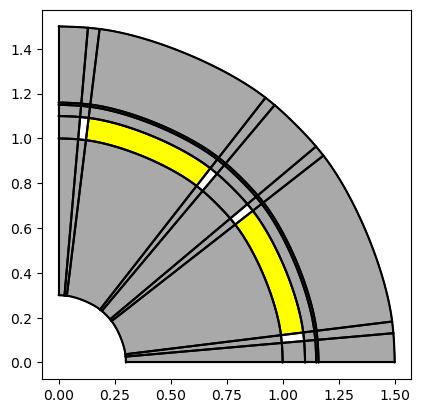

0


/tmp/ipykernel_5550/2753238448.py:23: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  uh_a.append(LS.complete((cholesky(LS.A))(LS.b)))


Residual contributions took 0.39487147331237793 seconds.
Jump contributions took 0.4766695499420166 seconds.
Refinement took 0.02811741828918457 seconds
Basis setup took 0.04219484329223633 seconds
Prolongation took 0.035400390625 seconds


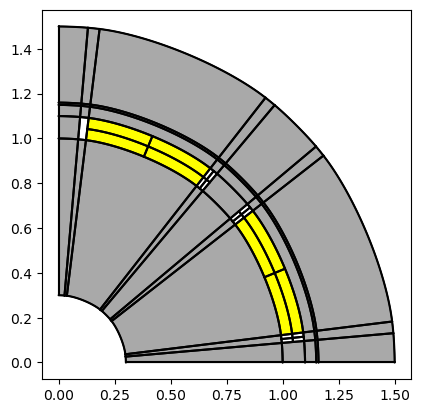

1
Residual contributions took 0.4704885482788086 seconds.
Jump contributions took 0.7044844627380371 seconds.
Refinement took 0.09058141708374023 seconds
Basis setup took 0.06496000289916992 seconds
Prolongation took 0.08070182800292969 seconds


KeyboardInterrupt: 

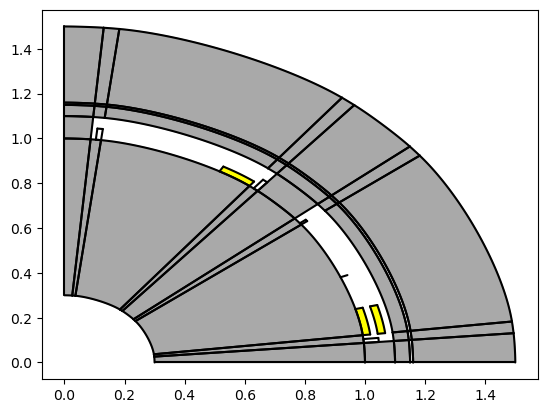

In [5]:
deg=2
M_a=Motor(deg,deg+1,full=False)
MP_a = assemble.Multipatch(M_a, automatch=True)
uh_a=[]
P_a=[]
err_ind=[]

maxiter=4
numdofs_a =np.zeros(maxiter)
err_est=np.zeros(maxiter)

for i in range(maxiter):
    MP_a.mesh.draw(color={'M1':'yellow', 'M2':'yellow','Fe':'darkgrey','Air':'white'})
    plt.show()
    print(i)
    bcs = MP_a.compute_dirichlet_bcs({0:0.})
    Ah_a = sum([MP_a.assemble_volume(vform.stiffness_vf(2,a=nu[k]),domain_id=k) for k in nu])
    F = sum([MP_a.assemble_volume('(j * v - inner(Ma_T, grad(v))) * dx', arity=1, domain_id=k, Ma_T=Ma_T[k], j=j[k], physical=True) for k in j],axis=0)
    Kh_a = MP_a.assemble_volume(vform.stiffness_vf(2))
    Mh_a = MP_a.assemble_volume(vform.mass_vf(2))
    #print(Ah.shape)
    LS = assemble.RestrictedLinearSystem(Ah_a, F, bcs)
    uh_a.append(LS.complete((cholesky(LS.A))(LS.b)))
    numdofs_a[i] = MP_a.numdofs
    #print(MP_a.numdofs)
    
    if i < maxiter-2 :
        err_ind.append(adap.PoissonEstimator(MP_a,uh_a[-1],f=j,a=nu, MaT=Ma_T, physical=True))
        err_est[i] = norm(err_ind[-1])
        marked_patches = adap.doerfler_marking(err_ind[-1], 0.9)
        marked_patches = {p:None for p in marked_patches}
        P_a.append(MP_a.h_refine(h_ref=marked_patches, return_P=True))
        MP_a.mesh.sanity_check()
        MP_a.sanity_check()
        #MP_a.mesh.draw(plt.figure())
    elif i == maxiter-2:
        P_a.append(MP_a.p_refine(p_inc=1, return_P=True))
    else:
        pass
    
for k in reversed(range(1,len(P_a))):
    P_a[k-1]=P_a[k]@P_a[k-1]
    
L2err_a = np.zeros(maxiter)
H1err_a = np.zeros(maxiter)
Aherr_a = np.zeros(maxiter)
for i in range(len(uh_a)-1):
    eh = P_a[i]@uh_a[i]-uh_a[-1]
    L2err_a[i] = eh @ Mh_a @ eh
    H1err_a[i] = eh @ Kh_a @ eh + L2err_a[-1]
    Aherr_a[i] = eh @ Ah_a @ eh
    
L2err_a = sqrt(L2err_a)
H1err_a = sqrt(H1err_a)
Aherr_a = sqrt(Aherr_a)

np.savetxt('Mp'+str(deg)+'n'+str(deg+1)+'.txt', np.c_[[numdofs_a,H1err_a,L2err_a,Aherr_a]])

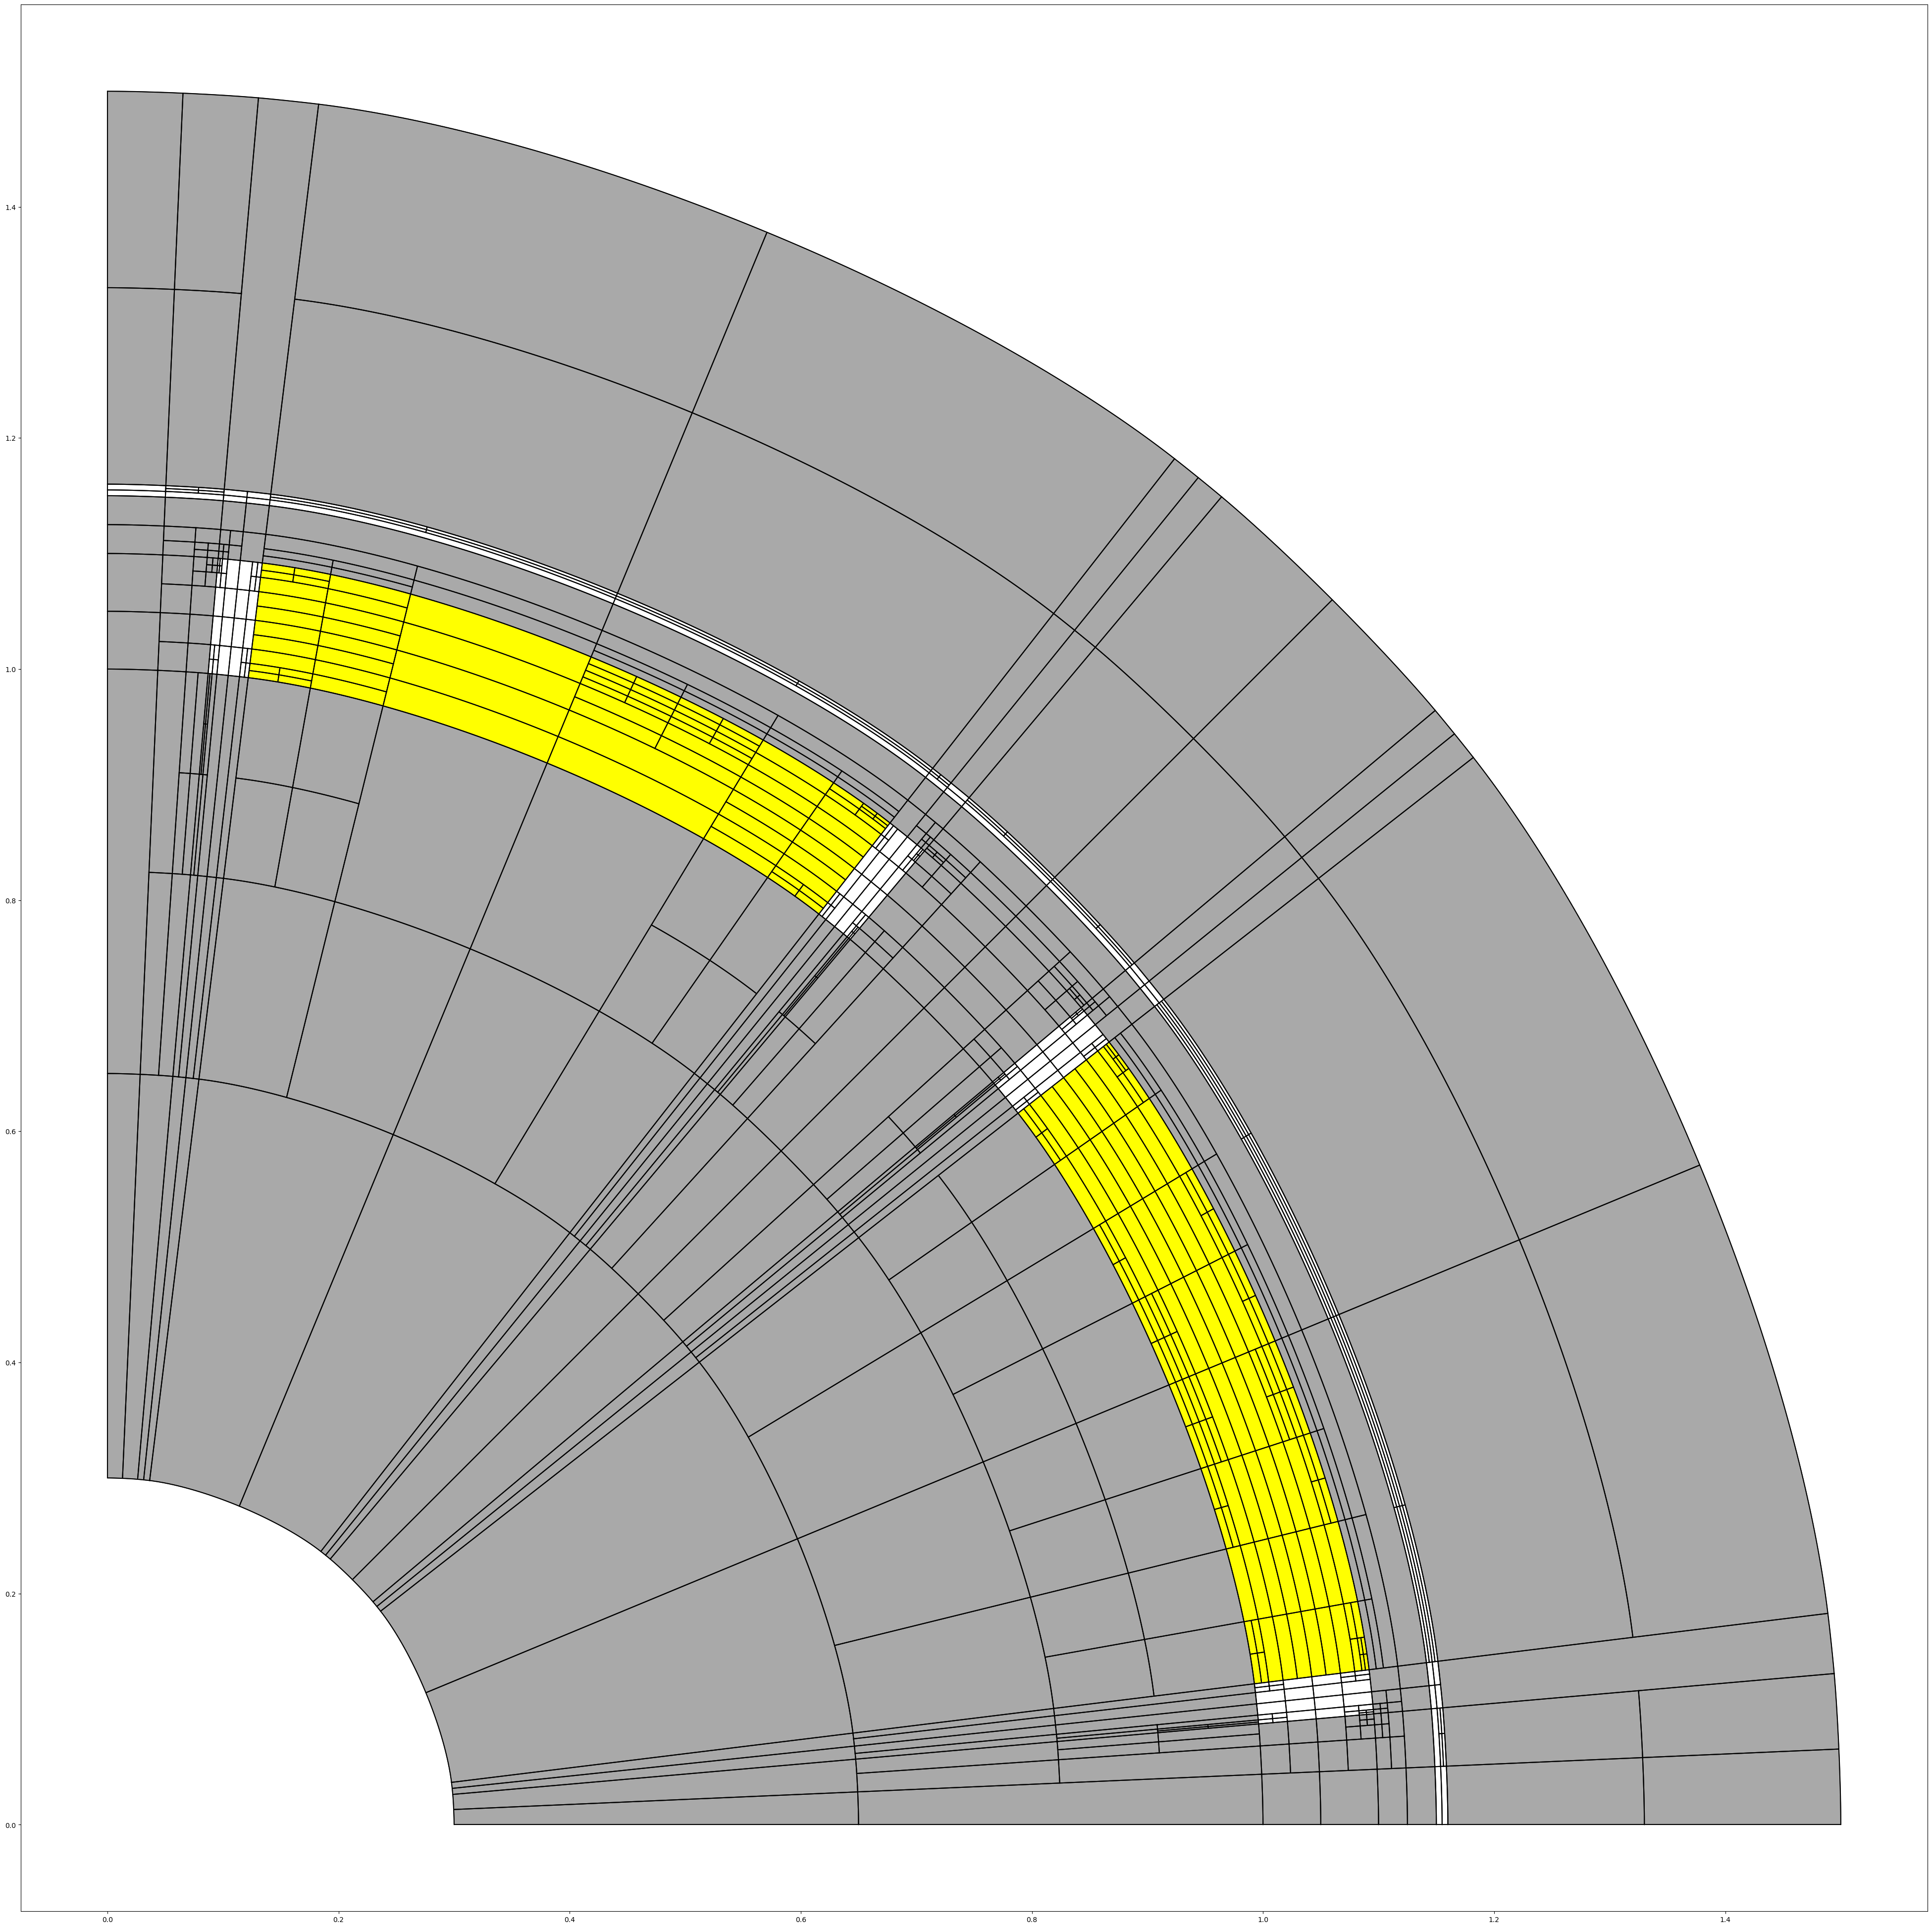

In [7]:
MP_a.mesh.draw(figsize=(50,50),color={'M1':'yellow', 'M2':'yellow','Fe':'darkgrey','Air':'white'},knots=False)

In [3]:
H1err_a

NameError: name 'H1err_a' is not defined

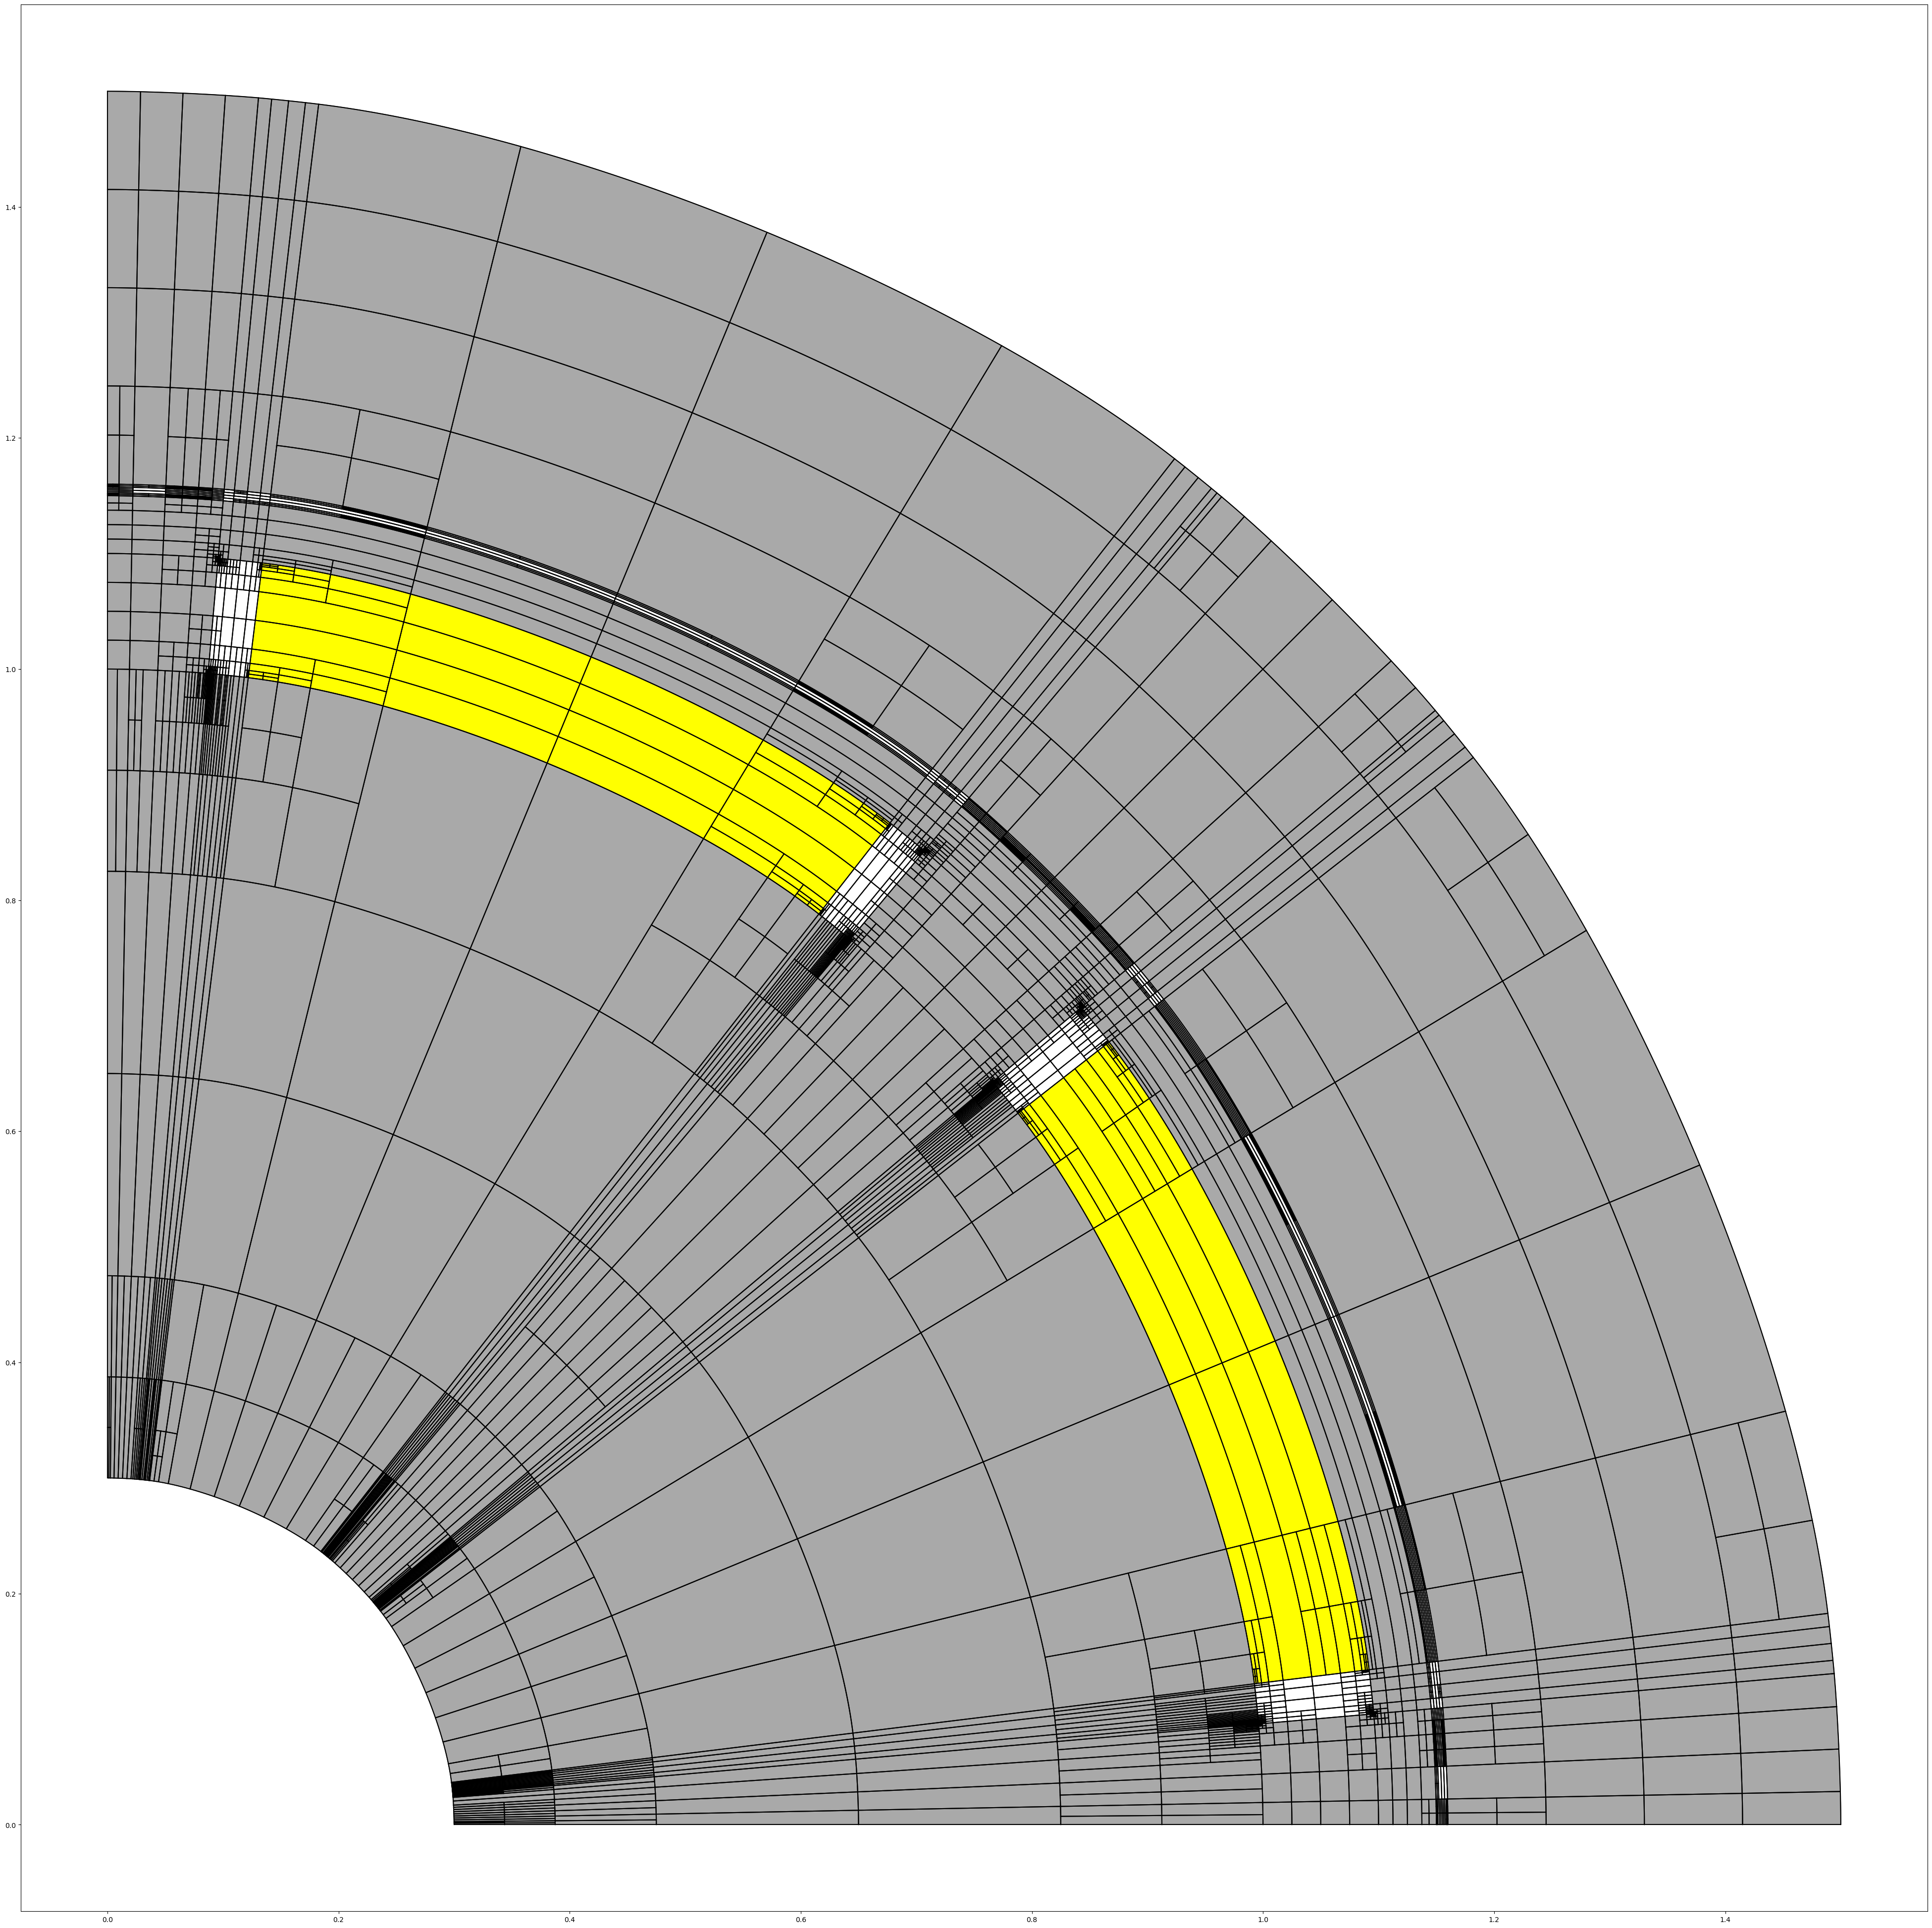

In [20]:
MP_a.mesh.draw(figsize=(50,50),color={'M1':'yellow', 'M2':'yellow','Fe':'darkgrey','Air':'white'})

In [9]:
L2err_a

array([2.06012e-07, 1.86646e-07, 8.49463e-08, 5.60222e-08, 3.89257e-08, 3.49324e-08, 1.02920e-08, 7.31785e-09, 6.86935e-09, 0.00000e+00])

In [7]:
err=adap.PoissonEstimator(MP,uh,f=j,a=nu, M=Ma_T, physical=True)

residual contributions took 1.468482255935669 seconds.
jump contributions took 2.404148817062378 seconds.


In [8]:
marked=adap.doerfler_marking(err,theta=0.8)

In [9]:
marked

[52, 132, 92, 12, 128, 8, 48, 88, 133, 13, 93, 53, 51]

Detecting interfaces took 10.848761081695557 seconds.


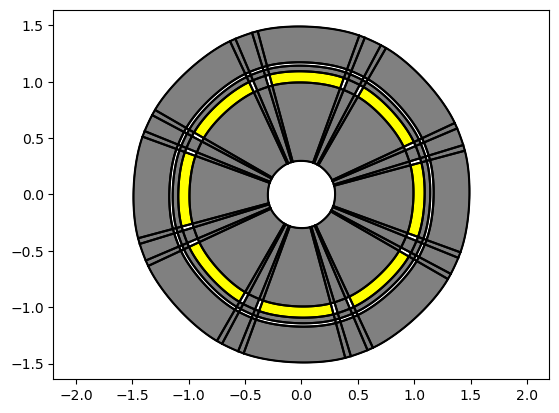

In [46]:
M=Motor(deg,deg+1)
M.draw(fig=plt.figure(),knots=False,color={'M1':'yellow', 'M2':'yellow','Fe':'grey','Air':'white'})
axis('equal');

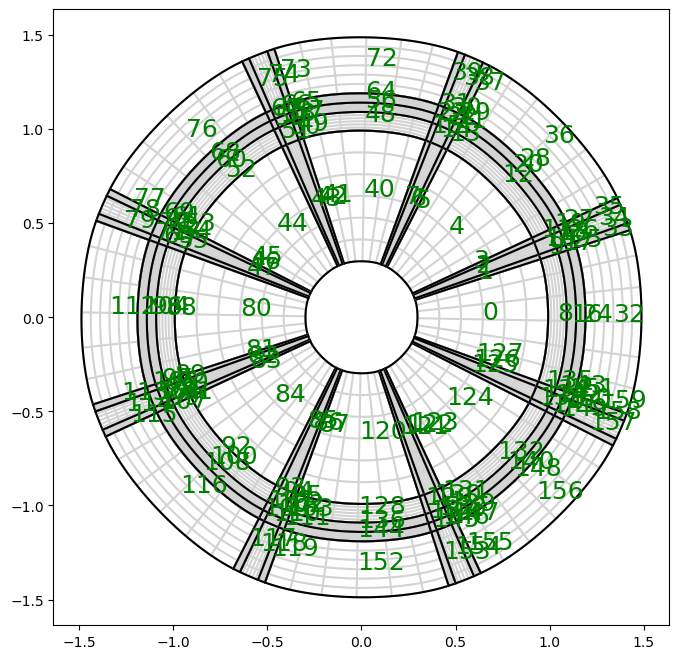

In [8]:
M.draw(patch_idx=True)
axis('scaled');

In [72]:
kvs, geo = M.patches[0][0]

In [73]:
F=assemble.assemble('inner(rho*nu*(-x[1],x[0]), grad(v)) * dx', kvs, arity=1, geo=geo, nu=nu['M1'], rho=1.28).ravel()

In [76]:
F.shape

(121,)

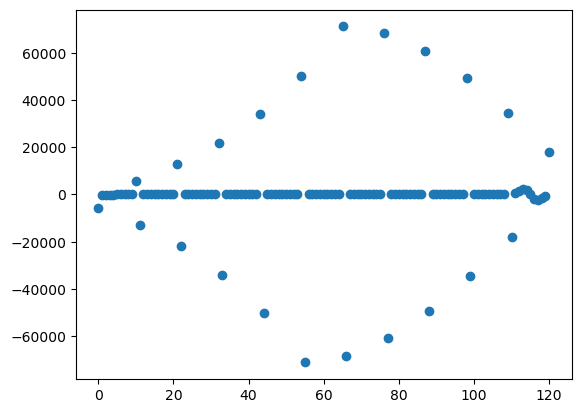

In [40]:
scatter(np.arange(len(F)),F)

In [65]:
vf = vform.VForm(2, arity=1)
v = vf.basisfuns()
M = vf.input('M')
vf.add(f * v * dx)

NameError: name 'dx' is not defined

In [2]:
M=topology.PatchMesh([(2*(bspline.make_knots(2,0.0,1.0,4),),geometry.unit_square())])
M.h_refine()
MP=assemble.Multipatch(M, automatch=True)

In [3]:
u_ = MP.L2projection(lambda x,y: x**2+y**2)

AttributeError: 'Figure' object has no attribute 'get_array'

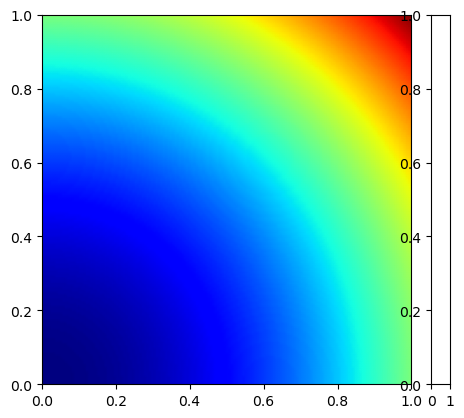

In [4]:
MP.plot(plt.figure(),u_)

In [5]:
fig=plt.figure()

<Figure size 640x480 with 0 Axes>